In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.diagnostic as sm_diag

## Download the time series of the daily evolution of several stocks with $dt = 1$min and creating white noise

[*********************100%***********************]  4 of 4 completed


<AxesSubplot:xlabel='days'>

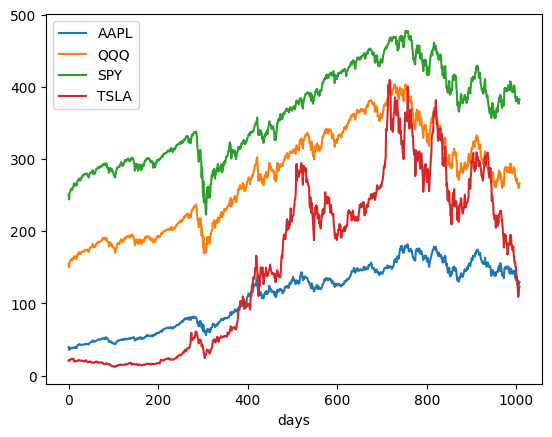

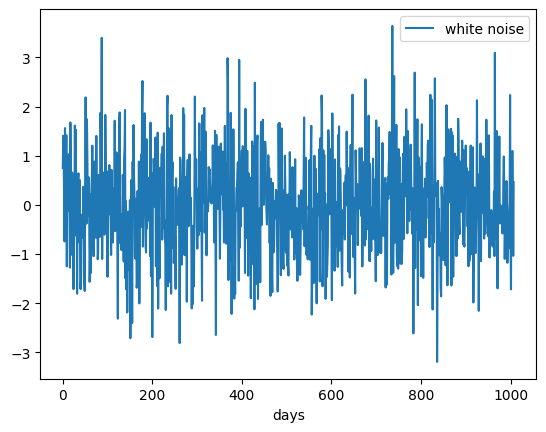

In [2]:
#download data of stock from yahoo finance
tickers = ['SPY','QQQ','AAPL','TSLA']

data = yf.download(tickers=tickers,start=pd.to_datetime('01/01/2019'),end=pd.to_datetime('01/01/2023'), interval='1d').Close.dropna()
data['days']=range(len(data.index))
data=data.set_index('days')

data.plot()

#create dataframe for the white noise
wn = pd.DataFrame(data = np.transpose(np.random.normal(size=len(data.index))), 
                  index = data.index, 
                  columns = ['white noise'])
wn.plot()

## Calculate ACFs and PACFs for a single stock on price, returns, log-returns and white noise 
It tells us that we are in an ARIMA(1,1,1) situation  for the stock price

Text(0, 0.5, 'PACF')

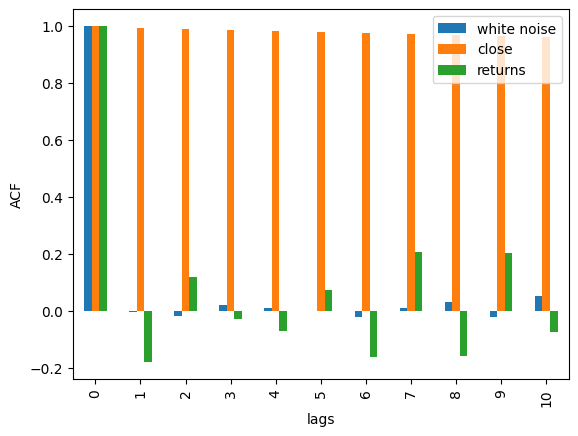

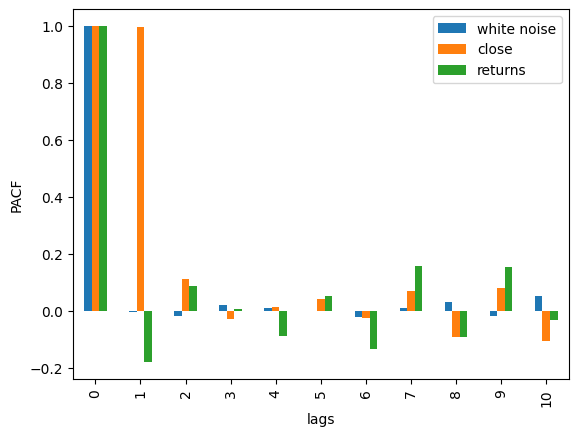

In [3]:
#find the ACFs for white noise, stock price and returns
stock=data[['SPY']]
returns=stock.pct_change().dropna()
log_returns=np.log(returns+1)
stock=stock[1:]

acorr1 = sm.tsa.acf(wn, nlags = 10)
acorr2 = sm.tsa.acf(stock, nlags = 10)
acorr3 = sm.tsa.acf(returns, nlags = 10)

#plot the ACFs using pandas plot function
df = pd.DataFrame(data = np.transpose([acorr1,acorr2,acorr3]), 
                  index = range(11), 
                  columns = ['white noise','close','returns'])
plt1 = df.plot( kind="bar")
plt1.set_xlabel('lags')
plt1.set_ylabel('ACF')

#find the PACFs for white noise, stock price and returns
acorr1 = sm.tsa.pacf(wn, nlags = 10)
acorr2 = sm.tsa.pacf(stock, nlags = 10)
acorr3 = sm.tsa.pacf(returns, nlags = 10)

#plot the ACFs using pandas plot function
df = pd.DataFrame(data = np.transpose([acorr1,acorr2,acorr3]), 
                  index = range(11), 
                  columns = ['white noise','close','returns'])
plt1 = df.plot( kind="bar")
plt1.set_xlabel('lags')
plt1.set_ylabel('PACF')

## Q-Q plot for the different time series

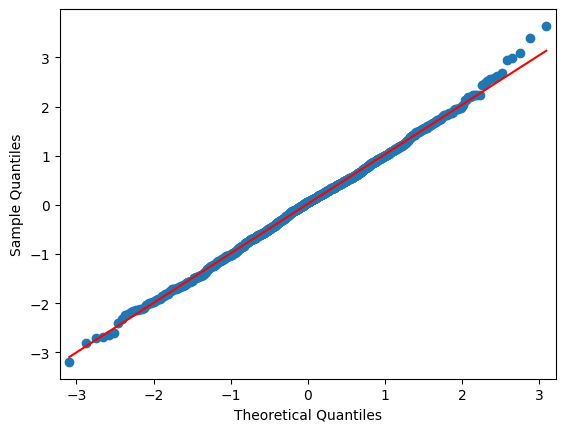

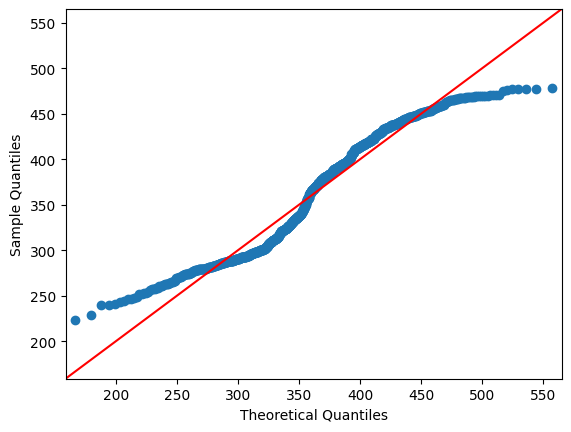

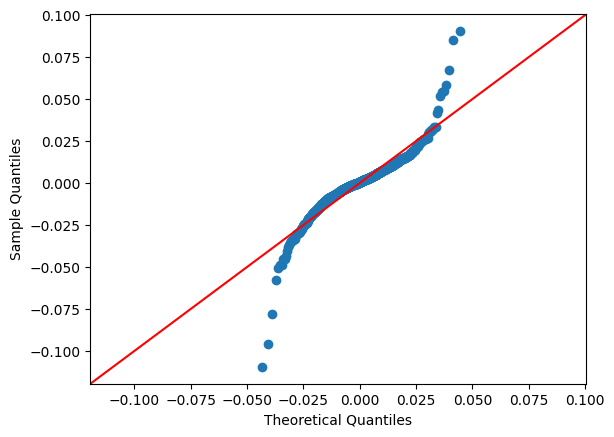

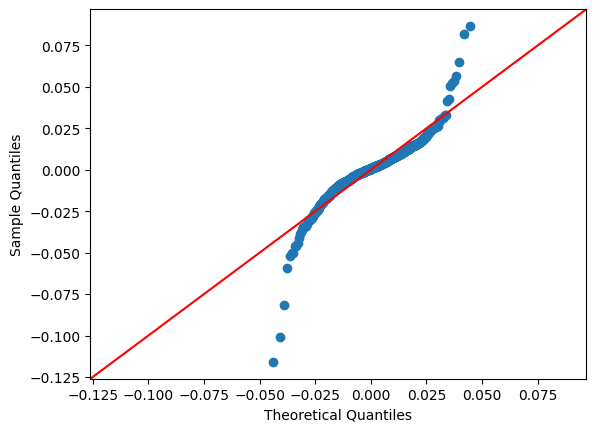

In [4]:
sm.qqplot(wn['white noise'].values, line ='s')
sm.qqplot(stock[stock.columns[0]].values,loc=stock.mean()[0],scale=stock.std()[0], line ='45')
sm.qqplot(returns[returns.columns[0]].values,loc=returns.mean()[0],scale=returns.std()[0], line ='45')
sm.qqplot(log_returns[log_returns.columns[0]].values,loc=log_returns.mean()[0],scale=log_returns.std()[0], line ='45');

## Fitting the stock with ARIMA(1,1,1) model and forecasting

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1007
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2992.574
Date:                Thu, 24 Aug 2023   AIC                           5991.147
Time:                        15:23:00   BIC                           6005.889
Sample:                             0   HQIC                          5996.748
                               - 1007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4013      0.129     -3.118      0.002      -0.654      -0.149
ma.L1          0.2937      0.136      2.160      0.031       0.027       0.560
sigma2        22.4562      0.586     38.292      0.0

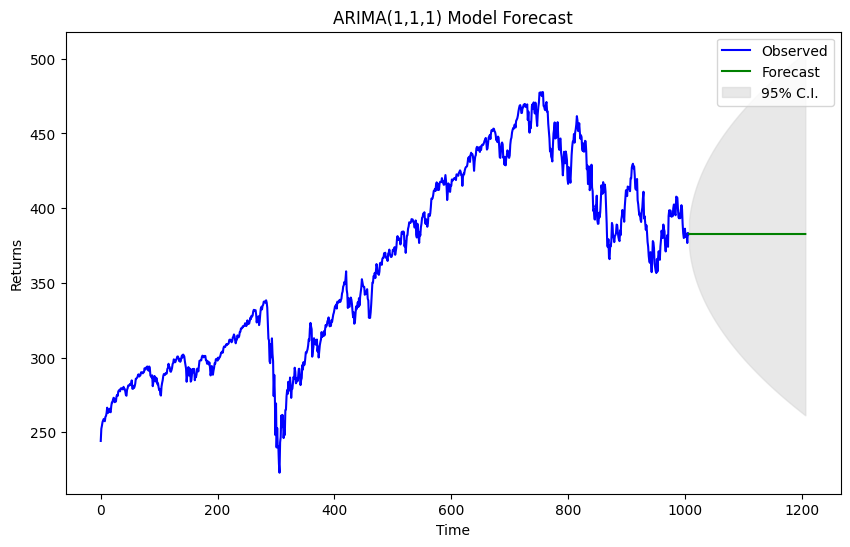

In [5]:
arima_model = sm.tsa.ARIMA(stock[stock.columns[0]].values, order=(1, 1, 1))
fitted_model = arima_model.fit()
print(fitted_model.summary())


# Get the number of periods for the forecast
n_forecast_periods = 200  # Adjust this according to your desired forecast horizon
returns_series = stock[stock.columns[0]].values

# Forecast returns for the next 'n_forecast_periods' periods
forecast_results = fitted_model.get_forecast(steps=n_forecast_periods)

# Extract the forecasted values and their confidence intervals
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

# Plot the original series
plt.figure(figsize=(10, 6))
plt.plot(returns_series, label='Observed', color='blue')

# Plot the in-sample and forecasted values
start_idx = len(returns_series)
end_idx = start_idx + n_forecast_periods
plt.plot(np.arange(start_idx, end_idx), forecast, label='Forecast', color='green')

# Plot the confidence intervals
plt.fill_between(np.arange(start_idx, end_idx), \
    conf_int[:,0], conf_int[:,1], color='lightgray', alpha=0.5, label='95% C.I.')

plt.xlabel('Time')
plt.ylabel('Returns')
plt.title('ARIMA(1,1,1) Model Forecast')
plt.legend()
plt.show()

## Analysis of the residual

Text(0, 0.5, 'PACF')

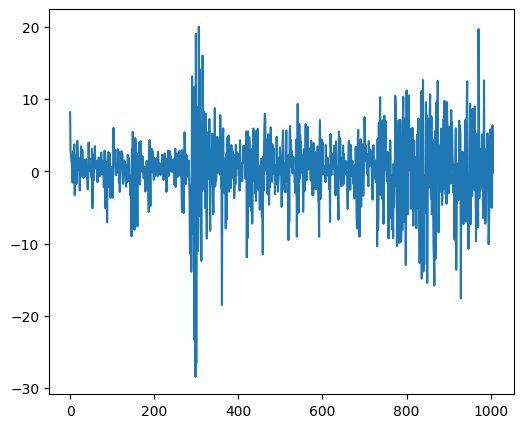

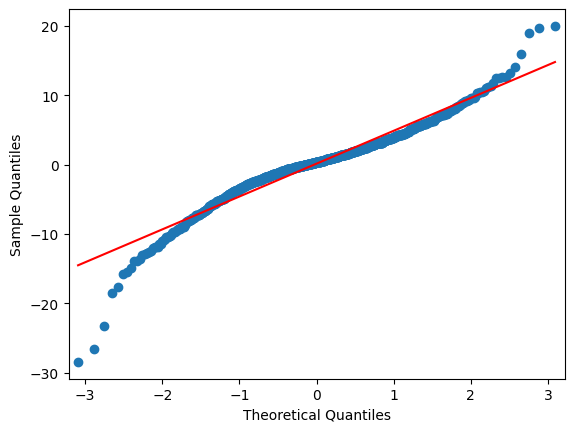

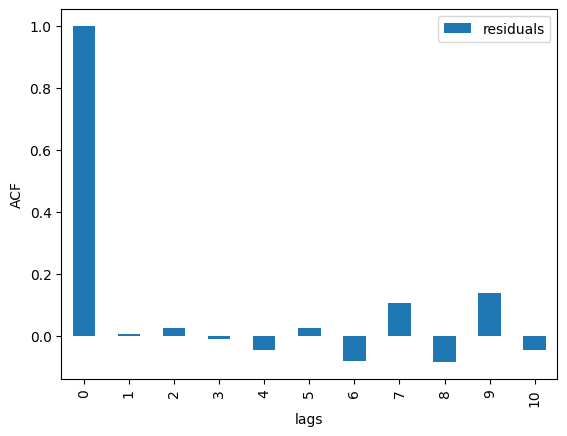

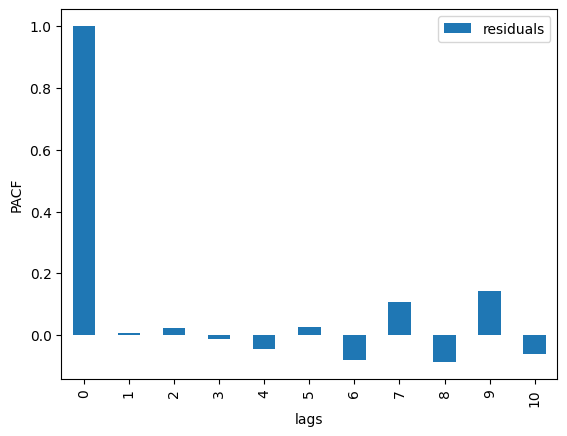

In [6]:
# Get the residuals of the model
residuals = fitted_model.resid[1:]

plt.figure(figsize=(6, 5))
plt.plot(residuals)

sm.qqplot(residuals, line='s')

#plot the ACFs using pandas plot function
acorr1 = sm.tsa.acf(residuals, nlags = 10)
df = pd.DataFrame(data = acorr1, 
                  index = range(11), 
                  columns = ['residuals'])
plt1 = df.plot( kind="bar")
plt1.set_xlabel('lags')
plt1.set_ylabel('ACF')

#plot the ACFs using pandas plot function
acorr1 = sm.tsa.pacf(residuals, nlags = 10)
df = pd.DataFrame(data = acorr1, 
                  index = range(11), 
                  columns = ['residuals'])
plt1 = df.plot( kind="bar")
plt1.set_xlabel('lags')
plt1.set_ylabel('PACF')

## ARMA(1,1) for the log returns and forecasting

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1007
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2866.457
Date:                Thu, 24 Aug 2023   AIC                          -5724.913
Time:                        15:23:01   BIC                          -5705.255
Sample:                             0   HQIC                         -5717.444
                               - 1007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.990      0.322      -0.000       0.001
ar.L1         -0.5578      0.054    -10.346      0.000      -0.663      -0.452
ma.L1          0.3971      0.060      6.644      0.0

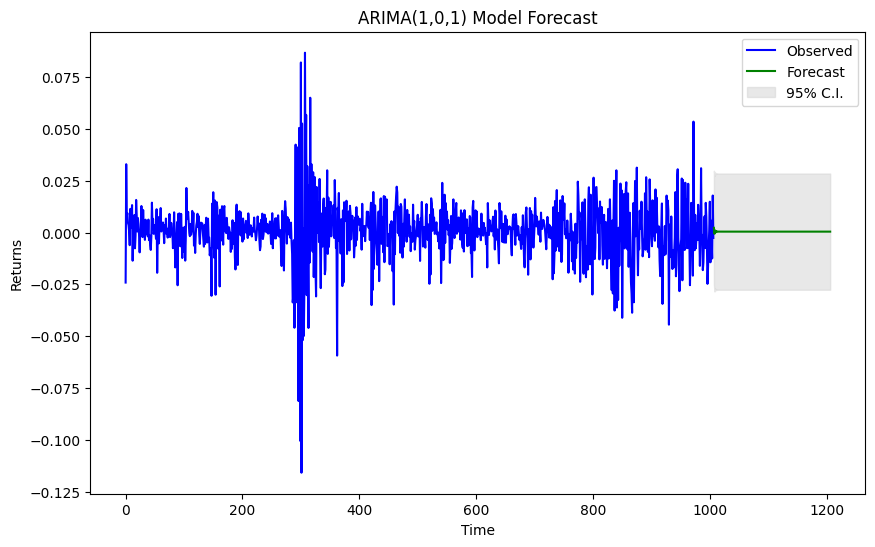

In [7]:
arima_model = sm.tsa.ARIMA(log_returns[log_returns.columns[0]].values, order=(1,0, 1))
fitted_model = arima_model.fit()
print(fitted_model.summary())


# Get the number of periods for the forecast
n_forecast_periods = 200  # Adjust this according to your desired forecast horizon
returns_series = log_returns[log_returns.columns[0]].values

# Forecast returns for the next 'n_forecast_periods' periods
forecast_results = fitted_model.get_forecast(steps=n_forecast_periods)

# Extract the forecasted values and their confidence intervals
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

# Plot the original series
plt.figure(figsize=(10, 6))
plt.plot(returns_series, label='Observed', color='blue')

# Plot the in-sample and forecasted values
start_idx = len(returns_series)
end_idx = start_idx + n_forecast_periods
plt.plot(np.arange(start_idx, end_idx), forecast, label='Forecast', color='green')

# Plot the confidence intervals
plt.fill_between(np.arange(start_idx, end_idx), \
    conf_int[:,0], conf_int[:,1], color='lightgray', alpha=0.5, label='95% C.I.')

plt.xlabel('Time')
plt.ylabel('Returns')
plt.title('ARIMA(1,0,1) Model Forecast')
plt.legend()
plt.show()

## Analysis of the residual

Text(0, 0.5, 'PACF')

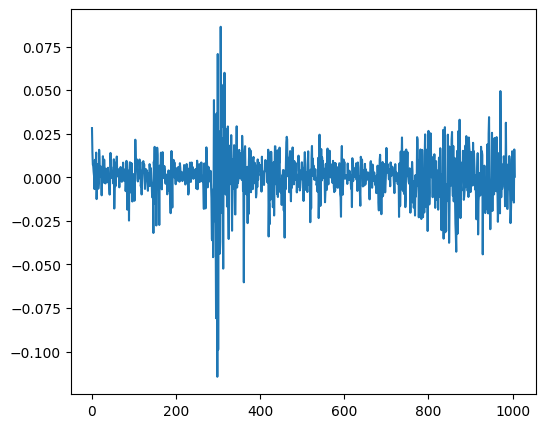

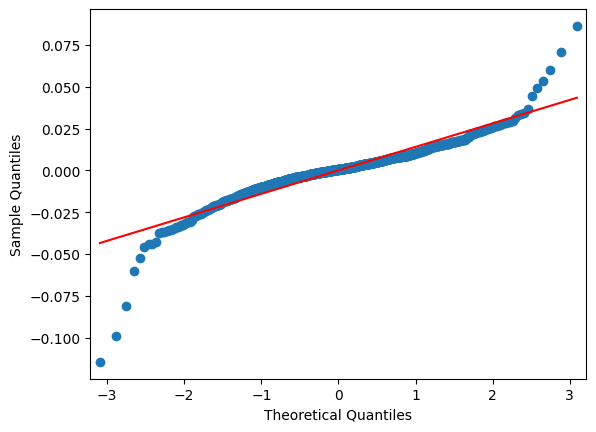

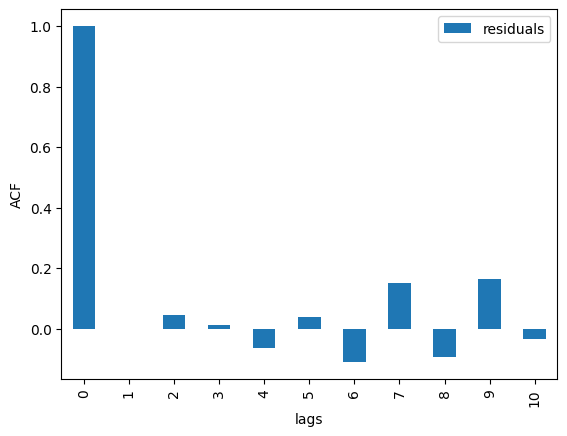

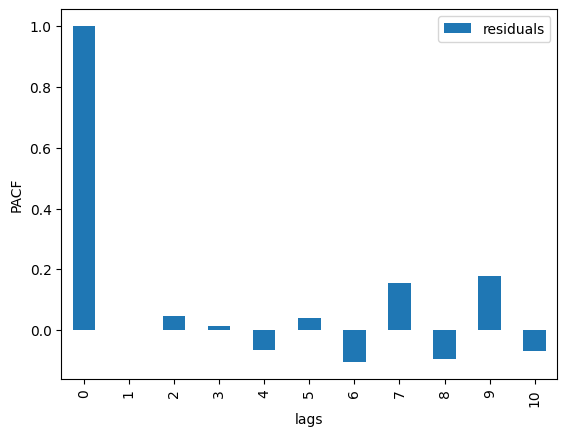

In [8]:
# Get the residuals of the model
residuals = fitted_model.resid[1:]

plt.figure(figsize=(6, 5))
plt.plot(residuals)

sm.qqplot(residuals, line='s')

#plot the ACFs using pandas plot function
acorr1 = sm.tsa.acf(residuals, nlags = 10)
df = pd.DataFrame(data = acorr1, 
                  index = range(11), 
                  columns = ['residuals'])
plt1 = df.plot( kind="bar")
plt1.set_xlabel('lags')
plt1.set_ylabel('ACF')

#plot the ACFs using pandas plot function
acorr1 = sm.tsa.pacf(residuals, nlags = 10)
df = pd.DataFrame(data = acorr1, 
                  index = range(11), 
                  columns = ['residuals'])
plt1 = df.plot( kind="bar")
plt1.set_xlabel('lags')
plt1.set_ylabel('PACF')

In [9]:
sm.tsa.acf(returns, nlags = 10)

array([ 1.        , -0.18035048,  0.11834386, -0.02795896, -0.06920101,
        0.07220121, -0.16195313,  0.20657889, -0.15964663,  0.2029284 ,
       -0.07429529])